In [1]:
from itertools import permutations
from sys import maxsize
from random import randrange
from inputs.in1 import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
cost = np.array(cost)

North West Corner is an Algorithm for calculating feasible solution

[Read more...](https://geekrodion.com/blog/operations/corner)

In [3]:
def north_west_corner(src, des):
    supply = list(map(supplies.get, src))
    demand = list(map(demands.get, des))

    i, j, fs = 0, 0, []

    while supply[len(supply) - 1] != 0:
        s, d = supply[i], demand[j]
        v = min(s, d)
        fs.append([[src[i], des[j]], v])

        supply[i] -= v
        demand[j] -= v

        if supply[i] == 0 and i < len(supply) - 1:
            i += 1
        if demand[j] == 0 and j < len(demand) - 1:
            j += 1

    return fs

In [4]:
def fitness(sol, cost):
    return np.sum(np.multiply(cost, sol))

In [5]:
population = np.empty((0, 2), dtype=int)
optimal_solution = None
minimum_cost = maxsize

sources = list(supplies.keys())
destinations = list(demands.keys())
sol_list = set()
counter = 0

Creating initial population by generating permutations of supplies & demands and then running north west corner on them.

(some of solutions are duplicate, so we ignore them and don't add them to initial population)

In [6]:
for i in permutations(supplies):
    for j in permutations(demands):

        feasible_solution = north_west_corner(i, j)

        solution = np.zeros([len(supplies), len(demands)], dtype=int)

        for k in feasible_solution:
            solution[sources.index(k[0][0]),
                     destinations.index(k[0][1])] = k[1]

        if np.array_str(solution) not in sol_list:
            sol_list.add(np.array_str(solution))

            ft = fitness(solution, cost)
            if ft < minimum_cost:
                optimal_solution = solution
                minimum_cost = ft

            population = np.vstack([population, [solution, ft]])

        counter += 1
        if counter == MAX_POPULATION:
            break

    if counter == MAX_POPULATION:
        break
        
NORTH_WEST_CORNER_RES = minimum_cost

C:\Users\lvtin\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
print("Results NORTH WEST CORNER:", end="\n" * 2)
print("Minimum cost:", minimum_cost, end="\n" * 2)
print("Optimal solution:", optimal_solution, sep="\n")

Results NORTH WEST CORNER:

Minimum cost: 1246

Optimal solution:
[[0 0 8 0 0]
 [0 0 2 1 4]
 [6 3 0 0 0]
 [0 0 0 3 0]
 [0 5 0 0 0]]


In [8]:
# let's free some memory ;)
del sol_list, sources, destinations

Parent Selection: Random Selection

In [9]:
def selection():
    global population

    population = population[np.argsort(population[:, 1])]

    # Truncation
    population = population[:MAX_POPULATION]

    # Parent Selection: Random Selection
    np.random.shuffle(population)

In [10]:
def solution_repair(sol, demand):

    des_num = len(sol[0])
    offset = [0] * des_num

    tmp = np.sum(sol, axis=0)
    for i in range(des_num):
        offset[i] = tmp[i] - demand[i]

    for i in range(des_num):
        if offset[i] < 0:

            need = True
            j = 0

            while need and (j < des_num):
                if offset[j] > 0:

                    k = 0
                    has_extra = True

                    while k < len(sol) and has_extra:

                        val = min(offset[j], sol[k][j], abs(offset[i]))

                        sol[k][j] -= val
                        sol[k][i] += val

                        offset[i] += val
                        offset[j] -= val

                        if offset[j] == 0:
                            has_extra = False
                        if offset[i] == 0:
                            need = False

                        k += 1

                j += 1

In [11]:
def crossover():
    global optimal_solution, minimum_cost, population

    pool = np.empty((0, 2), dtype=int)

    if len(population) % 2 == 1:
        num = len(population) - 1
    else:
        num = len(population)

    for i in range(0, num, 2):
        if np.random.rand() <= CROSSOVER_RATE:

            child1 = population[i][0].copy()
            child2 = population[i+1][0].copy()

            comparison = (child1 == child2)
            if comparison.all():
                continue

            demand = np.sum(child1, axis=0)

            crossover_row = randrange(len(child1))

            t1 = child1[crossover_row].copy()
            t2 = child2[crossover_row].copy()
            child1[crossover_row] = t2
            child2[crossover_row] = t1

            solution_repair(child1, demand)
            solution_repair(child2, demand)

            ft = fitness(child1, cost)
            if ft < minimum_cost:
                optimal_solution = child1
                minimum_cost = ft

            pool = np.vstack([pool, [child1, ft]])

            ft = fitness(child2, cost)
            if ft < minimum_cost:
                optimal_solution = child2
                minimum_cost = ft

            pool = np.vstack([pool, [child2, ft]])

    population = np.vstack([population, pool])

Random submatrixs are generated for mutation.

In [12]:
def random_submatrix(mtx):
    tmp = mtx[len(mtx)-1:]

    i, j = np.where(tmp != 0)

    ti = randrange(len(i))

    SE = (i[ti] + 1, j[ti])

    # because randrange(0) is false
    if SE[1] == 0:
        NW = (randrange(SE[0]), 0)
    else:
        NW = (randrange(SE[0]), randrange(SE[1]))

    NE = (NW[0], SE[1])
    SW = (SE[0], NW[1])

    return NW, NE, SW, SE

In [13]:
def mutation():
    global optimal_solution, minimum_cost, population

    pool = np.empty((0, 2), dtype=int)

    for i in range(0, len(population)):
        if np.random.rand() <= MUTATION_RATE:

            solution = population[i][0].copy()

            NW, NE, SW, SE = random_submatrix(solution)

            val = min(solution[NW[0]][NW[1]], solution[SE[0]][SE[1]])

            solution[NW[0]][NW[1]] -= val
            solution[SE[0]][SE[1]] -= val
            solution[NE[0]][NE[1]] += val
            solution[SW[0]][SW[1]] += val

            ft = fitness(solution, cost)
            if ft < minimum_cost:
                optimal_solution = solution
                minimum_cost = ft

            pool = np.vstack([pool, [solution, ft]])

    population = np.vstack([population, pool])

Running genetic algorithm.

In [14]:
def ga():
    print("ITERATION_NUM:", ITERATION_NUM)
    print("MAX_POPULATION:", MAX_POPULATION)
    print("CROSSOVER_RATE:", CROSSOVER_RATE)
    print("MUTATION_RATE:", MUTATION_RATE)
    for i in range(ITERATION_NUM):
        selection()
        crossover()
        mutation()
        
    print("Minimum cost:", minimum_cost, end="\n" * 2)

In [15]:
ga();

print("Results AFTER applying GA:", end="\n" * 2)
print("Minimum cost:", minimum_cost, end="\n" * 2)
print("Optimal solution:", optimal_solution, sep="\n")

ITERATION_NUM: 100
MAX_POPULATION: 500
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

Results AFTER applying GA:

Minimum cost: 1102

Optimal solution:
[[0 0 8 0 0]
 [0 0 0 4 3]
 [5 4 0 0 0]
 [1 0 2 0 0]
 [0 4 0 0 1]]


ITERATION_NUM: 10
MAX_POPULATION: 500
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 100
MAX_POPULATION: 500
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 250
MAX_POPULATION: 500
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

[10, 100, 250, 500]
[1246, 1246, 1246, 1246]
[1102, 1102, 1102, 1102]


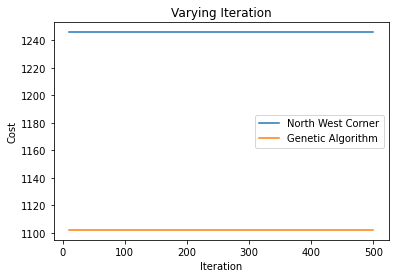

In [16]:
x = [10, 100, 250, 500]
y1 = []
y2 = []

for i in x:
    optimal_solution = None
    minimum_cost = maxsize
    ITERATION_NUM = i
    ga();
    y1.append(NORTH_WEST_CORNER_RES)
    y2.append(minimum_cost)


print(x)
print(y1)
print(y2)

    
plt.plot(x, y1, label = "North West Corner")
plt.plot(x, y2, label = "Genetic Algorithm")

# Set labels of the current axis
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('Varying Iteration')
plt.legend()

# Display a figure.
plt.show()

# Reset
ITERATION_NUM = 500

ITERATION_NUM: 500
MAX_POPULATION: 10
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 100
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 250
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 1
MUTATION_RATE: 1
Minimum cost: 1102

[10, 100, 250, 500]
[1246, 1246, 1246, 1246]
[1102, 1102, 1102, 1102]


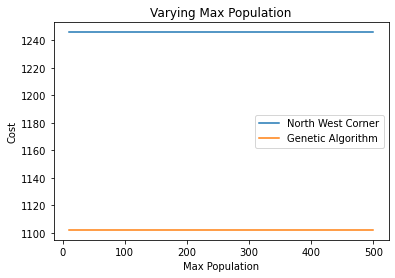

In [17]:
x = [10, 100, 250, 500]
y1 = []
y2 = []

for i in x:
    optimal_solution = None
    minimum_cost = maxsize
    MAX_POPULATION = i
    ga();
    y1.append(NORTH_WEST_CORNER_RES)
    y2.append(minimum_cost)


print(x)
print(y1)
print(y2)

    
plt.plot(x, y1, label = "North West Corner")
plt.plot(x, y2, label = "Genetic Algorithm")

# Set labels of the current axis
plt.xlabel('Max Population')
plt.ylabel('Cost')
plt.title('Varying Max Population')
plt.legend()

# Display a figure.
plt.show()

# Reset
MAX_POPULATION = 500

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 0.1
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 0.3
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 0.5
MUTATION_RATE: 1
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 0.8
MUTATION_RATE: 1
Minimum cost: 1102

[0.1, 0.3, 0.5, 0.8]
[1246, 1246, 1246, 1246]
[1102, 1102, 1102, 1102]


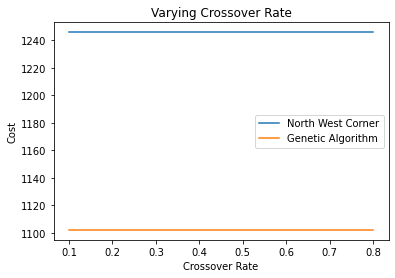

In [18]:
x = [0.1, 0.3, 0.5, 0.8]
y1 = []
y2 = []

for i in x:
    optimal_solution = None
    minimum_cost = maxsize
    CROSSOVER_RATE = i
    ga();
    y1.append(NORTH_WEST_CORNER_RES)
    y2.append(minimum_cost)



print(x)
print(y1)
print(y2)

    
plt.plot(x, y1, label = "North West Corner")
plt.plot(x, y2, label = "Genetic Algorithm")

# Set labels of the current axis
plt.xlabel('Crossover Rate')
plt.ylabel('Cost')
plt.title('Varying Crossover Rate')
plt.legend()

# Display a figure.
plt.show()

# Reset
CROSSOVER_RATE = 0.5

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 0.5
MUTATION_RATE: 0.1
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 0.5
MUTATION_RATE: 0.25
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 0.5
MUTATION_RATE: 0.5
Minimum cost: 1102

ITERATION_NUM: 500
MAX_POPULATION: 500
CROSSOVER_RATE: 0.5
MUTATION_RATE: 0.75
Minimum cost: 1102

[0.1, 0.25, 0.5, 0.75]
[1246, 1246, 1246, 1246]
[1102, 1102, 1102, 1102]


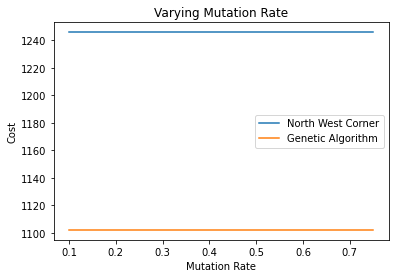

In [19]:
x = [0.1, 0.25, 0.5, 0.75]
y1 = []
y2 = []

for i in x:
    optimal_solution = None
    minimum_cost = maxsize
    MUTATION_RATE = i
    ga();
    y1.append(NORTH_WEST_CORNER_RES)
    y2.append(minimum_cost)



print(x)
print(y1)
print(y2)

    
plt.plot(x, y1, label = "North West Corner")
plt.plot(x, y2, label = "Genetic Algorithm")

# Set labels of the current axis
plt.xlabel('Mutation Rate')
plt.ylabel('Cost')
plt.title('Varying Mutation Rate')
plt.legend()

# Display a figure.
plt.show()

# Reset
MUTATION_RATE = 0.5